In [1]:
import os
import base64
import joblib
import pandas as pd
import numpy as np
import category_encoders

import math

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix, pairwise, precision_recall_curve, roc_curve
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.base import BaseEstimator, TransformerMixin

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def get_unique_values(s):
    values_list = s.replace(' ', '').split(';')
    
    values_list = [i for i in values_list if i in ['E', 'S', 'N']]
    
    unique_values = set(values_list)
    unique_values_str = ', '.join(unique_values)
    
    if unique_values_str == '':
        return 'unknown'
    else:
        return unique_values_str

def make_confmat_pretty(confmat):
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.4)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i,
                    s=confmat[i, j],
                    va='center', ha='center')
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.title('Confusion Matrix')
    plt.show()
    
#Function to separate categorical and numerical features to insert in pipeline
def separate_cat_num_feat(df, columns_drop=None):
    if columns_drop:
        features = df.drop(columns=columns_drop).columns.tolist()
    else:
        features = df.columns.tolist()
    
    categorical_features = [i for i in features if df[i].dtype == 'object' or df[i].dtype == 'bool']
    numerical_features = [i for i in features if df[i].dtype == 'int64' or df[i].dtype == 'float']
    
    if len(features) != len(categorical_features) + len(numerical_features):
        print('Warning, there are missing categories in the separation procedure')
        print('Features length: {}, categorical_features length: {}, numerical_features length: {}'.format(len(features),
                                                                                                           len(categorical_features),
                                                                                                           len(numerical_features)))
        print(df.dtypes)
    return categorical_features, numerical_features

def calc_amount_metrics(df, y_pred):
    df['prediction'] = y_pred
    
    fpa = df[(df['label'] == 0) & (df['prediction'] == 1)]['amount_usd'].sum()
    tpa = df[(df['label'] == 1) & (df['prediction'] == 1)]['amount_usd'].sum()
    
    fp = df[(df['label'] == 0) & (df['prediction'] == 1)].shape[0]
    tn = df[(df['label'] == 0) & (df['prediction'] == 0)].shape[0]

    fpa = df[(df['label'] == 0) & (df['prediction'] == 1)]['amount_usd'].sum()
    tna = df[(df['label'] == 0) & (df['prediction'] == 0)]['amount_usd'].sum()
    
    tpa = tpa/(tpa+fpa)
    fpr = fp/(fp+tn)
    fpa = fpa/(fpa+tna)
    
    return round(tpa*100, 2), round(fpr*100, 2), round(fpa*100, 2)

# Extracting Data

In [3]:
df_test = pd.read_csv("complete_test.csv").set_index('order_id')
df_train = pd.read_csv("train.csv").set_index('order_id')
features = df_train.columns.to_list()
print(df_train.shape)

(195401, 15)


In [4]:
df_train.head()

,order_date,amount_usd,payment_method,billing_address_country_code,shipping_address_country_code,avs_code,email_amount_spent_avg_180d,email_orders_count_180d,session_visitor_type,shipping_method_type,card_expiration_date,bin_brand,bin_type,label,suspicious_activity_score
order_id,,,,,,,,,,,,,,,
181852054,2022-06-02 15:28:13,611.03,payment_method_2,SA,SA,avs_code_8,NaN,NaN,returning,E,05/2025,mastercard,credit,0.0,7.801596
181265052,2022-05-21 15:53:20,334.44,payment_method_1,FR,FR,avs_code_1,591.141667,6.0,returning,S,NaN,NaN,NaN,0.0,8.117476
149633145,2021-09-30 09:05:06,611.85,payment_method_1,HK,HK,avs_code_1,NaN,NaN,returning,E;E,NaN,NaN,NaN,0.0,6.240885
149158895,2021-09-22 15:19:15,198.18,payment_method_2,RU,RU,avs_code_5,473.027368,38.0,returning,E,03/2023,visa,debit,0.0,5.188745
169664695,2022-02-18 08:59:32,434.71,payment_method_3,HK,HK,avs_code_5,NaN,NaN,returning,E,NaN,NaN,NaN,0.0,5.738602


# EDA

In [4]:
df_train.dtypes

order_date                        object
amount_usd                       float64
payment_method                    object
billing_address_country_code      object
shipping_address_country_code     object
avs_code                          object
email_amount_spent_avg_180d      float64
email_orders_count_180d          float64
session_visitor_type              object
shipping_method_type              object
card_expiration_date              object
bin_brand                         object
bin_type                          object
label                            float64
suspicious_activity_score        float64
dtype: object

In [7]:
df_train.nunique()

order_date                       174799
amount_usd                        83602
payment_method                        8
billing_address_country_code        166
shipping_address_country_code       166
avs_code                             24
email_amount_spent_avg_180d       82105
email_orders_count_180d             665
session_visitor_type                  2
shipping_method_type                156
card_expiration_date                187
bin_brand                            10
bin_type                              3
label                                 2
suspicious_activity_score        190343
dtype: int64

In [6]:
df_train.isnull().sum()

order_date                           0
amount_usd                           0
payment_method                     622
billing_address_country_code        21
shipping_address_country_code       17
avs_code                          3467
email_amount_spent_avg_180d      95444
email_orders_count_180d          96131
session_visitor_type             35812
shipping_method_type                 0
card_expiration_date             60605
bin_brand                        61685
bin_type                         62099
label                               10
suspicious_activity_score            0
dtype: int64

In [14]:
df_train.describe()

,amount_usd,email_amount_spent_avg_180d,email_orders_count_180d,label,suspicious_activity_score
count,195401.000000,99957.000000,99270.000000,195391.000000,195401.000000
mean,416.202721,601.548982,16.563957,0.090178,11.172787
std,303.273803,613.567228,59.119859,0.286438,14.892533
min,0.770000,1.480000,1.000000,0.000000,0.177196
25%,192.480000,290.130000,1.000000,0.000000,4.409769
50%,320.490000,459.960000,4.000000,0.000000,6.317762
75%,551.780000,729.470000,10.000000,0.000000,9.452618
max,1499.780000,50585.300000,1355.000000,1.000000,69.523928


In [7]:
df_train.duplicated().sum()

5053

In [9]:
df_train.index.duplicated().sum()

5135

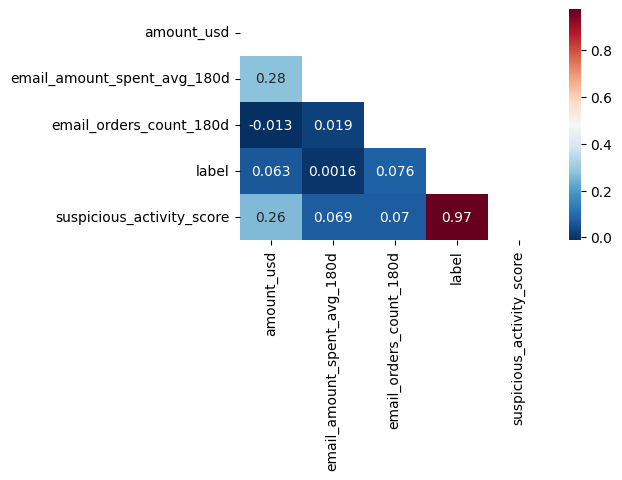

In [4]:
categorical_features, numerical_features = separate_cat_num_feat(df_train)

cor_mat = df_train[numerical_features].corr() 
lower_triangle_mask = np.triu(np.ones(cor_mat.shape)).astype(bool)
cor_mat_lower = cor_mat.mask(lower_triangle_mask)

plt.figure(figsize = (5,3)) 

sns.heatmap(cor_mat_lower, 
            annot=True, 
            cmap='RdBu_r');

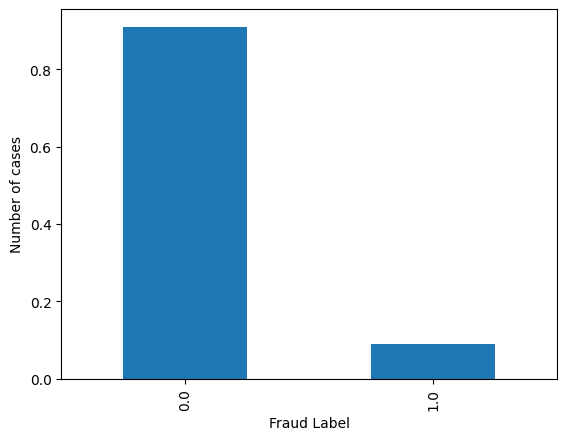

In [6]:
df_train.label.value_counts(normalize=True).plot(kind="bar");
plt.xlabel('Fraud Label');
plt.ylabel('Number of cases');

# Data Cleaning

In [4]:
def data_cleaner(df):
    df_ = df.copy()
    
    df_['email_amount_spent_avg_180d'].fillna(0, inplace=True) #NaN assumed that there is no prior amount spent
    df_['email_orders_count_180d'].fillna(0, inplace=True) #NaN assumed that there are no prior orders onde
    df_['session_visitor_type'].fillna('unknown', inplace=True)
    
    df_['bin_brand'].fillna('unknown', inplace=True)
    df_['bin_type'].fillna('unknown', inplace=True)
    df_['card_expiration_date'].fillna('unknown', inplace=True)
    
    df_['shipping_method_type'] = df_['shipping_method_type'].apply(get_unique_values) #cleaning values of this feature
    df_= df_.drop(columns=['suspicious_activity_score'])
    
    df_ = df_.drop_duplicates()
    df_ = df_.dropna()
    
    print('Nbr of obs: {}, ({}%)'.format(df_.shape[0], round(df_.shape[0]/df.shape[0]*100, 2)))
    return df_

df_train_clean = data_cleaner(df_train)
df_test_clean = data_cleaner(df_test)

Nbr of obs: 186329, (95.36%)
Nbr of obs: 57937, (99.52%)


# Feature Engineering

In [5]:
class Daytime(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X=None, y=None, **fit_params):
        return self
    def transform(self, data):
        X = data.copy()
        X['order_date'] = pd.to_datetime(X['order_date'], infer_datetime_format=True)
        X['day_of_week'] = X['order_date'].dt.strftime('%A')
        X['time_of_day'] = X['order_date'].dt.hour.apply(lambda x: 'morning' if x < 12 else ('afternoon' if x < 20 else 'evening'))

        return X 

In [6]:
class MaxAvg180Ratio(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X=None, y=None, **fit_params):
        return self
    def transform(self, data):
        X = data.copy()
        X['avg_180_max_ratio'] = X['email_amount_spent_avg_180d']/X['amount_usd']
        
        return X 

In [7]:
class SameCountryAdress(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X=None, y=None, **fit_params):
        return self
    def transform(self, data):
        X = data.copy()
        X['same_country_address'] = np.where(X['billing_address_country_code'] == X['shipping_address_country_code'], True, False)
        return X 

In [8]:
class YearMonth(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X=None, y=None, **fit_params):
        return self
    def transform(self, data):
        X = data.copy()
        X['year_month'] = X['order_date'].astype(str).str[:7]
        X = X.drop(columns=['order_date'])
        return X 

# Creating the Model

/tmp/ipykernel_835/1706677285.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  X['order_date'] = pd.to_datetime(X['order_date'], infer_datetime_format=True)
/tmp/ipykernel_835/1706677285.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  X['order_date'] = pd.to_datetime(X['order_date'], infer_datetime_format=True)


General
ROCAUC score:0.822134957797958
f1_score:0.3847510286338064
precision:0.24373636895579553
recall:0.9129308627216577

True Positive Amount: 27.09%
False Positive Rate: 26.87%
False Positive Amount: 29.43%


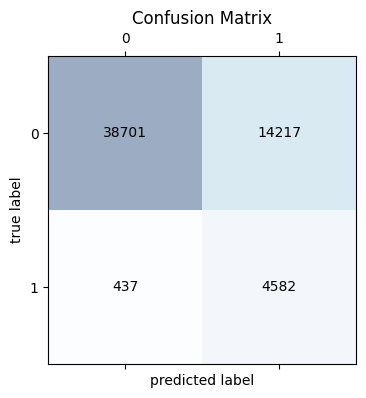

In [11]:
categorical_features, numerical_features = separate_cat_num_feat(df_train_clean, ['label', 'order_date'])
target = 'label'

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

numerical_transformer = Pipeline(steps=[
                                       ('scaler', StandardScaler())])

                                   
                                   
preprocessor = ColumnTransformer(
    transformers=[("cat", categorical_transformer, categorical_features),
                  ("num", numerical_transformer, numerical_features)]
)

pipeline = Pipeline([
    ("feat_engineering_1", Daytime()),
    ("feat_engineering_2", MaxAvg180Ratio()),
    ("feat_engineering_3", SameCountryAdress()),
    ("feat_engineering_4", YearMonth()),
    ("preprocessor", preprocessor),
    ('model', RandomForestClassifier(max_depth=10, random_state=42, n_jobs=-1))
])


X_train = df_train_clean.drop(columns=['label'])
y_train = df_train_clean[target]

X_test = df_test_clean.drop(columns=['label'])
y_test = df_test_clean[target]

#Performing oversampling (sampling_strategy coeff. chosen for scoring purposes)
ros_sampler = RandomOverSampler(sampling_strategy=1, random_state=42)
X_train, y_train = ros_sampler.fit_resample(X_train, y_train)


pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)


print('General')
print('ROCAUC score:{}'.format(roc_auc_score(y_test, y_pred)))
print('f1_score:{}'.format(f1_score(y_test, y_pred)))
print('precision:{}'.format(precision_score(y_test, y_pred)))
print('recall:{}\n'.format(recall_score(y_test, y_pred)))

tpa, fpr, fpa = calc_amount_metrics(df_test_clean, y_pred)                          
print('True Positive Amount: {}%'.format(tpa))
print('False Positive Rate: {}%'.format(fpr))
print('False Positive Amount: {}%'.format(fpa))

confmat = confusion_matrix(y_true=y_test, 
                           y_pred=y_pred)
make_confmat_pretty(confmat)

### ROC-AUC Score

/tmp/ipykernel_186/1706677285.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  X['order_date'] = pd.to_datetime(X['order_date'], infer_datetime_format=True)


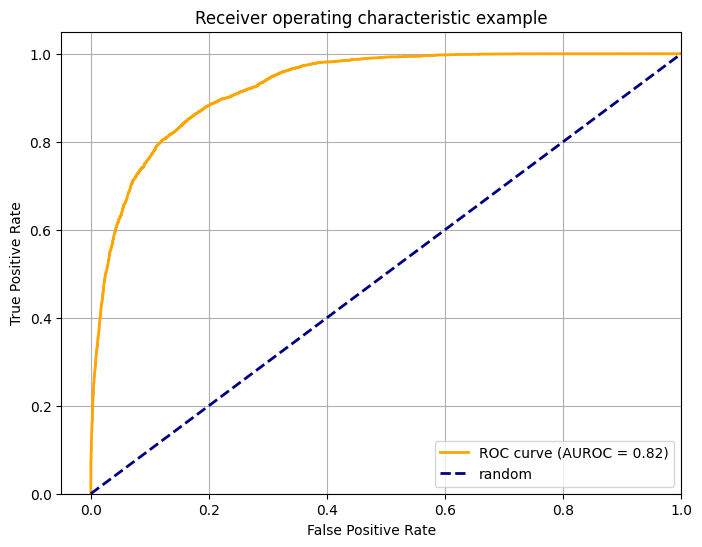

In [16]:
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_score=pipeline.predict_proba(X_test)[:,1], y_true=y_test)
def plot_roc_curve(roc_auc, fpr, tpr):
    
    plt.figure(figsize=(8,6))
    lw = 2
    plt.plot(fpr, tpr, color='orange', lw=lw, label='ROC curve (AUROC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='random')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
plot_roc_curve(roc_auc, fpr, tpr)

##### Load the test set

In [14]:
test = pd.read_csv('test.csv').set_index("order_id")

##### Use the pipeline to get predictions (very simple!)

In [ ]:
y_scores_final = pipeline.predict_proba(test)[:,1]

##### Prepare the submissions file

In [ ]:
submission = pd.Series(y_scores_final,index=test.index, name='order_id')
submission.to_csv("submission.csv")